# Initializations

In [3]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

from PIL import Image

import sys
sys.path.append("../ml-model/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, WeightedRandomSampler



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [5]:
%%px --local 

from skimage.transform import resize
from skimage.io import imread, imsave

def read_img(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    img = img / img.max()
    return img

# Define & exemplify stats of interest

In [6]:
myfile = '/home/data/world-cities//train/very-large/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'
myfile

'/home/data/world-cities//train/very-large/SAR_fr_paris,-fr-(pop-2.1M)_very-large_2110694_48.8667_2.3333.png'

#### Fraction of occupied area

In [7]:
%%px --local 

compute_pct_occupied = lambda img: (img).sum() / float(img.shape[0]*img.shape[1])

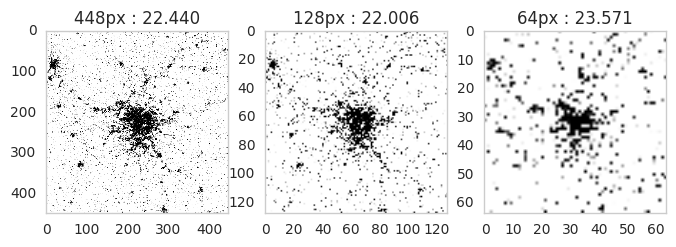

In [8]:
# using PIL (which is what torchvision uses)

img = grayscale_loader(myfile)

img_64 = img.resize((64,64))
img_128= img.resize((128,128))

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("448px : %2.3f"%compute_pct_occupied(np.array(img)))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(np.array(img_128)))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(np.array(img_64)))

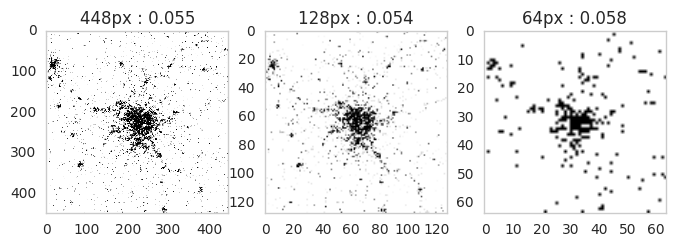

In [9]:
# using skimage

img = read_img(myfile)

img_64 = resize(img, (64,64), preserve_range=True)
img_128= resize(img, (128,128), preserve_range=True)

fig, ax = plt.subplots(1,3, figsize=(8,4))
ax[0].imshow(img); ax[0].set_title("448px : %2.3f"%compute_pct_occupied(img))
ax[1].imshow(img_128); ax[1].set_title("128px : %2.3f"%compute_pct_occupied(img_128))
ax[2].imshow(img_64); ax[2].set_title("64px : %2.3f"%compute_pct_occupied(img_64))

#### Distribution of patch areas

In [10]:
%%px --local 

from skimage import morphology

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

def compute_patch_area_distribution(img, bins=None):
    areas, mask = compute_patch_areas(img)
    area_sizes = [x[1] for x in areas]
    N_counts, bins = np.histogram(area_sizes, bins=bins)
    mask = None; area_sizes = None
    return np.log(N_counts), bins, areas

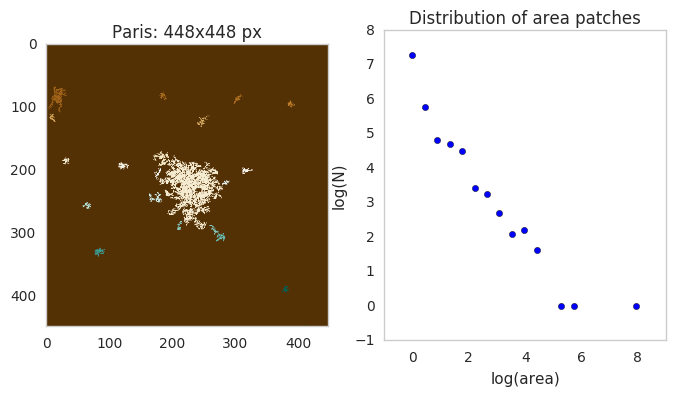

In [11]:
areas, mask = compute_patch_areas(img)

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 448x448 px")

# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

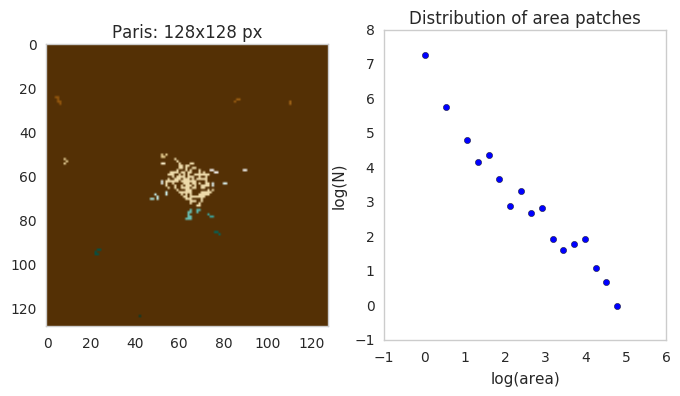

In [12]:
areas, mask = compute_patch_areas(resize(img, (128,128), preserve_range=True))

area_sizes = [x[1] for x in areas]
log_area_bins = np.logspace(np.log(min(area_sizes)), np.log(max(area_sizes)), 20, base=np.exp(1))
log_N, _, _ = compute_patch_area_distribution(img, bins=log_area_bins)

# plot just top 20 areas
mask1 = mask.copy()
for a in areas[20:]:
    mask1[mask1==a[0]] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
imgplot = ax[0].imshow(mask1)
imgplot.set_cmap('BrBG')
ax[0].set_title("Paris: 128x128 px")


# plot distribution of area sizes
ax[1].scatter(np.log(log_area_bins[:-1]), log_N, marker="o")
ax[1].set_title("Distribution of area patches")
ax[1].set_ylabel("log(N)")
ax[1].set_xlabel("log(area)")

In [13]:
%%px --local 

import scipy.misc

def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    sizes = None; counts = None
    return -coeffs[0]

('Minkowski-Bouligand dimension (computed): ', 1.632332986123719)
('Haussdorf dimension (theoretical):        ', 1.5849625007211563)


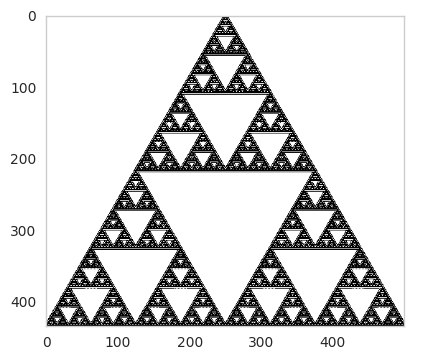

In [14]:
I = read_img("sierpinski.png")
plt.imshow(1-I)
print("Minkowski-Bouligand dimension (computed): ", fractal_dimension(I))
print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))
frac_dim = fractal_dimension(img)

### Pick out a good range

In [54]:

# TODO
# plot of count vs sizes

# leave out few points beginning/end 
# minimum scale to keep fractality?
# use LOES robust estimator 

In [15]:
frac_dim

1.6533453455442277

# Set up data sources: real data

In [16]:
dataroot = "/home/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [17]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['phase'] = 'train'

len(files_df)

24986

#### Test data is under ./test/ and contains more carefully-filtered samples

In [18]:
files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

# hack to remove some cities that are too close to Paris
# just an example we looked at
# this means that the filtering needs to be debugged
test_df = test_df[(~test_df['filename'].str.contains("argenteuil")) & \
                  (~test_df['filename'].str.contains("montreuil"))]

test_df['city'] = test_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
test_df['phase'] = 'test'

len(test_df)

3010

In [19]:
files_df = pd.concat([files_df, test_df], axis=0).reset_index().drop("index",1)

In [20]:
regions_df = pd.read_csv("/home/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)


#### Compute patch area distributions for a sample

In [22]:
compute_max_area = lambda res: max([np.log(compute_patch_areas(resize(read_img(f), (res,res), preserve_range=True))[0][0][1])\
                        for f in files_df.sample(100)['filename']])

max_area_orig = compute_max_area(448)
max_area_128  = compute_max_area(128)
max_area_64   = compaute_max_area(64)

log_area_bins_orig = np.logspace(1, max_area_orig, 20, base=np.exp(1))
log_area_bins_128 = np.logspace(1, max_area_128, 20, base=np.exp(1))
log_area_bins_64 = np.logspace(1, max_area_64, 20, base=np.exp(1))

max_area_orig, max_area_128, max_area_64

IndexError: list index out of range

In [23]:
max_area_orig

9.4535218170268998

# Set up data sources: simulations

In [ ]:
import glob

files_sim = glob.glob(dataroot + "/simulations/*/*.png")
files_sim_df = []
for f in files_sim:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    p = cls.split("_")
    Ue, gu, gr, T = int(p[0][2:]), float(p[1][2:]), float(p[2][2:]), float(p[3][1:])
    r = fname.replace(".png","").split("_")
    n, t = int(r[0]), int(r[1].replace("iter",""))
    files_sim_df.append((f, Ue, gu, gr, T, n, t))
    
files_sim_df = pd.DataFrame(files_sim_df, \
                columns=["filename", "Ue", "gu", "gr", "theta", "n", "t"])
files_sim_df['phase'] = 'train'

len(files_sim_df)

In [ ]:
files_sel = files_sim_df[files_sim_df['theta']>0.02]\
    .groupby(['Ue', 'gu', 'gr', 'theta', 'n', 'phase'], group_keys=False)\
    .apply(lambda x: x.sort('t', ascending=False).iloc[:(len(x)/2):5])
    
print len(files_sel)

In [ ]:
files_sel.head()

# Compute stats on all images

In [24]:
myfiles_df = files_df.copy() # real images
# myfiles_df = files_sel.copy() # simulated images

print len(myfiles_df)

27996


In [25]:
%%px --local

import numpy as np
import os

def compute_stats(f, imgSize=None, max_log_area=None):
    try:
        img = read_img(f.replace("//",'/'), imgSize) 
    except:
        return None, None, None, None
    pct_occupied = compute_pct_occupied(img)
    bins = np.logspace(1, max_log_area, 20, base=np.exp(1))
    log_N, _, areas = compute_patch_area_distribution(img, bins=bins)
    log_N[np.isinf(log_N)] = 0
    fd = fractal_dimension(img)
    
    top_k_areas = np.zeros(20)
    top_k_areas[:min([20,len(areas)])] = [x[1] for x in areas[:20]]
    
    img = None; bins = None;
    # gc.collect()
    return f, pct_occupied, log_N , fd, top_k_areas

In [26]:
f = myfiles_df['filename'].iloc[0]
f

'/home/data/world-cities//train/medium/SAR_in_itarsi,-in-(pop-100.6k)_medium_100585_22.6167_77.7500.png'

In [44]:
compute_stats(f, imgSize=None, max_log_area=4)

('/home/data/world-cities//train/medium/SAR_in_itarsi,-in-(pop-100.6k)_medium_100585_22.6167_77.7500.png',
 0.0052564971301020409,
 array([ 2.77258872,  0.        ,  2.07944154,  1.09861229,  0.        ,
         2.07944154,  1.09861229,  0.        ,  0.        ,  0.        ,
         0.69314718,  0.69314718,  0.        ,  0.69314718,  0.69314718,
         0.        ,  0.        ,  0.        ,  0.        ]),
 1.171773675784179,
 array([ 292.,   28.,   26.,   24.,   22.,   18.,   16.,   15.,   14.,
          10.,    9.,    8.,    8.,    8.,    7.,    7.,    7.,    7.,
           7.,    6.]))

In [33]:
%%timeit  
compute_stats(f, imgSize=None, max_log_area=9)

10 loops, best of 3: 121 ms per loop


In [29]:
%%timeit 
compute_stats(f, imgSize=128, max_log_area=6.7)

100 loops, best of 3: 3.64 ms per loop


In [30]:
%%timeit 
compute_stats(f, imgSize=64, max_log_area=6.0)

100 loops, best of 3: 2.76 ms per loop


In [ ]:
res_orig = lbv.map_async(lambda f: compute_stats(f, imgSize=None, max_log_area=9), \
                         myfiles_df['filename'].values.tolist())
stats_orig = pd.DataFrame(res_orig.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim", "top patch areas"])

In [ ]:
res_128 = lbv.map_async(lambda f: compute_stats(f, imgSize=128, max_log_area=6), \
                         myfiles_df['filename'].values.tolist())
stats_128 = pd.DataFrame(res_128.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim", "top patch areas"])

In [ ]:
res_64 = lbv.map_async(lambda f: compute_stats(f, imgSize=64, max_log_area=5), \
                         myfiles_df['filename'].values.tolist())
stats_64 = pd.DataFrame(res_64.result(), 
                          columns=["filename", "build pct", 
                                   "patch distr", "fractal dim", "top patch areas"])

In [ ]:
myfiles_df = pd.concat([myfiles_df.reset_index().drop("index",1), 
    stats_128.rename(columns={"build pct":"build pct 128", 
                               "fractal dim":"fractal dim 128",
                               "top patch areas":"top patch areas 128",
                               "patch distr":"patch distr 128"}).drop("filename",1),
    stats_orig.rename(columns={"build pct":"build pct 448", 
                               "fractal dim":"fractal dim 448",
                               "top patch areas":"top patch areas 448",
                               "patch distr":"patch distr 448"}).drop("filename",1),
    stats_64.rename(columns={"build pct":"build pct 64", 
                               "fractal dim":"fractal dim 64",
                               "top patch areas":"top patch areas 64",
                               "patch distr":"patch distr 64"}).drop("filename",1)
], axis=1)

myfiles_df.dropna(inplace=True)

In [53]:
myfiles_df.head()

,filename,class,country,population,city,phase,region,build pct 128,patch distr 128,fractal dim 128,top patch areas 128,build pct 448,patch distr 448,fractal dim 448,top patch areas 448,build pct 64,patch distr 64,fractal dim 64,top patch areas 64,decile
0,/home/data/world-cities//train/medium/SAR_in_i...,medium,in,100585,"itarsi, in (pop 100.6k)",train,Asia,0.011440,"[0.0, 0.69314718056, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.551278,"[4.0, 4.0, 3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0.005256,"[3.17805383035, 1.79175946923, 2.19722457734, ...",1.171774,"[292.0, 28.0, 26.0, 24.0, 22.0, 18.0, 16.0, 15...",0.012975,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.987537,"[7.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,/home/data/world-cities//train/medium/SAR_co_s...,medium,co,126553,"sogamoso, co (pop 126.6k)",train,Americas,0.003207,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.533348,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.001794,"[2.56494935746, 1.60943791243, 1.38629436112, ...",0.832452,"[53.0, 35.0, 26.0, 13.0, 10.0, 10.0, 9.0, 8.0,...",0.002289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.683710,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,/home/data/world-cities//train/medium/SAR_us_l...,medium,us,140772,"lakewood, us (pop 140.8k)",train,Americas,0.027446,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.030878,"[43.0, 12.0, 10.0, 7.0, 2.0, 2.0, 2.0, 2.0, 2....",0.019402,"[3.09104245336, 2.56494935746, 1.79175946923, ...",1.122282,"[2711.0, 102.0, 100.0, 68.0, 56.0, 47.0, 45.0,...",0.026681,"[0.0, 1.09861228867, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.048507,"[21.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 2.0, 1.0,...",5
3,/home/data/world-cities//train/medium/SAR_br_t...,medium,br,251647,"taubate, br (pop 251.6k)",train,Americas,0.038727,"[1.60943791243, 0.69314718056, 1.09861228867, ...",1.233724,"[80.0, 7.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0,...",0.026696,"[4.27666611902, 3.49650756147, 3.21887582487, ...",1.300396,"[1982.0, 239.0, 226.0, 196.0, 166.0, 80.0, 79....",0.038245,"[0.0, 0.69314718056, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.387306,"[36.0, 8.0, 6.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0,...",6
4,/home/data/world-cities//train/medium/SAR_ve_m...,medium,ve,105511,"mariara, ve (pop 105.5k)",train,Americas,0.030704,"[1.38629436112, 0.0, 1.09861228867, 0.0, 0.0, ...",1.202455,"[30.0, 21.0, 16.0, 8.0, 6.0, 5.0, 5.0, 5.0, 4....",0.021719,"[3.89182029811, 3.04452243772, 2.56494935746, ...",1.265432,"[868.0, 636.0, 585.0, 147.0, 119.0, 107.0, 85....",0.032483,"[0.69314718056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.296312,"[21.0, 15.0, 10.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2....",6


In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
myfiles_df[myfiles_df['phase']=='train']['build pct 128'].hist(bins=100, ax=ax)
q = myfiles_df[myfiles_df['phase']=='train']['build pct 128'].quantile(np.linspace(0.0,1,100))
ax2.plot(q, q.index, label="cdf", color="black")
sns.set_style("whitegrid", {'axes.grid' : False})
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
ax.set_xlabel("% built land", fontsize=14)
ax.set_ylabel("# cities", fontsize=14)
ax2.set_ylabel("% cities", fontsize=14)


In [ ]:
q = myfiles_df['build pct 128'].quantile(np.linspace(0.0,1,10))

print q

myfiles_df['decile'] = myfiles_df['build pct 128'].apply(lambda x: np.searchsorted(q.values, x) )

#### Save to file: real data

In [ ]:
train_df = myfiles_df[(myfiles_df['phase']=='train')]
train_df.to_csv(dataroot + "/urban_areas_over_10kpop_stats.csv")

test_df = myfiles_df[(myfiles_df['phase']=='test')]
test_df.to_csv(dataroot + "/urban_areas_over_10kpop_pruned_stats.csv")

len(train_df), len(test_df)

#### Save to file: simulations

In [ ]:
train_df = myfiles_df[(myfiles_df['phase']=='train')]
train_df.to_csv(dataroot + "/simulations_stats.csv")